In [ ]:
# classic ml
!pip install scikit-learn matplotlib numpy scipy seaborn
# deep learning
!pip install torch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from ipywidgets import interact, FloatSlider

plt.style.use("seaborn-v0_8")
np.random.seed(42)


In [2]:
def plot_decision_surface(model, X, y, ax, padding=0.5, resolution=200):
    """Plot decision regions for 2D inputs."""
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)
    zz = probs.argmax(axis=1).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.25, cmap="tab10")
    scatter = ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap="tab10", edgecolor="white", s=50
    )
    handles, labels = scatter.legend_elements()
    ax.legend(handles, labels, title="class")
    ax.set(xlabel="feature 1", ylabel="feature 2")


---
## Part 1 · Linear Regression: fit a line visually

In [3]:
# Synthetic regression data (one feature, gentle noise)
X_reg, y_reg = make_regression(
    n_samples=180,
    n_features=1,
    noise=15.0,
    bias=40.0,
    random_state=42
)

X_reg = X_reg.astype(np.float32)
y_reg = y_reg.astype(np.float32)


In [4]:
@interact(
    slope=FloatSlider(description="slope", min=-50, max=50, step=1, value=1.0),
    intercept=FloatSlider(description="intercept", min=-50.0, max=50, step=1.0, value=10.0)
)
def manual_line(slope, intercept):
    predictions = slope * X_reg[:, 0] + intercept
    mse = mean_squared_error(y_reg, predictions)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(X_reg[:, 0], y_reg, alpha=0.6, label="data")
    x_axis = np.linspace(X_reg.min() - 2, X_reg.max() + 2, 200)
    ax.plot(x_axis, slope * x_axis + intercept, color="tab:red", linewidth=2, label="your line")
    ax.set(title=f"Your line · MSE = {mse:.0f}", xlabel="feature", ylabel="target")
    ax.legend(loc="upper left")
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='slope', max=50.0, min=-50.0, step=1.0), FloatSlider(…

Once you have an intuition for the line, let scikit-learn find the best parameters automatically.

In [ ]:
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

lin_reg = LinearRegression()
lin_reg.fit(X_reg, y_reg)

slope = lin_reg.coef_[0]
intercept = lin_reg.intercept_
print(f"Learned slope: {slope:.2f}")
print(f"Learned intercept: {intercept:.2f}")


Learned slope: 21.08
Learned intercept: 42.59


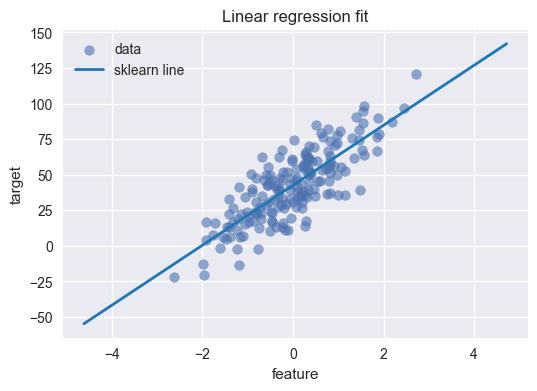

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_reg[:, 0], y_reg, alpha=0.6, label="data")
x_axis = np.linspace(X_reg.min() - 2, X_reg.max() + 2, 200)
y_axis = lin_reg.predict(x_axis.reshape(-1, 1))
ax.plot(x_axis, y_axis, color="tab:blue", linewidth=2, label="sklearn line")
ax.set(title="Linear regression fit", xlabel="feature", ylabel="target")
ax.legend(loc="upper left")
plt.show()

---
## Part 2 · Binary Logistic Regression: nudge the boundary

In [7]:
X_clf, y_clf = make_classification(
    n_samples=300,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    class_sep=1.3,
    flip_y=0.03,
    random_state=7
)


In [11]:
@interact(
    C=FloatSlider(description="1/λ", min=0.05, max=5.0, step=0.05, value=1.0),
    threshold=FloatSlider(description="threshold", min=0.1, max=0.9, step=0.05, value=0.5)
)
def logistic_playground(C, threshold):
    """Explore how regularization (via C) and decision threshold shift the classifier."""
    model = LogisticRegression(C=C, solver="lbfgs")
    model.fit(X_clf, y_clf)
    probs = model.predict_proba(X_clf)[:, 1]
    preds = (probs >= threshold).astype(int)
    acc = accuracy_score(y_clf, preds)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # Decision surface
    ax = axes[0]
    plot_decision_surface(model, X_clf, y_clf, ax)
    ax.set_title("Decision boundary")

    # Probability + threshold view
    ax = axes[1]
    ax.scatter(probs, np.zeros_like(probs), c=y_clf, cmap="coolwarm", alpha=0.6, edgecolor="white")
    ax.axvline(threshold, color="black", linestyle="--", label="threshold")
    ax.set(xlabel="Predicted probability of class 1", yticks=[])
    ax.legend()
    ax.set_title(f"Accuracy = {acc:.2f}")

    plt.tight_layout()
    plt.show()

    # [0, 1]. prediction_probability <= threshold -> 0, >threshold -> 1

interactive(children=(FloatSlider(value=1.0, description='1/λ', max=5.0, min=0.05, step=0.05), FloatSlider(val…

---
## Part 3 · Multiclass Logistic Regression: softmax in action

In [12]:
X_multi, y_multi = make_blobs(
    n_samples=450,
    centers=3,
    n_features=2,
    cluster_std=1.0,
    random_state=10
)


In [ ]:
@interact(C=FloatSlider(description="1/λ", min=0.1, max=3.0, step=0.1, value=1.0))
def softmax_regions(C):
    model = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=C)
    model.fit(X_multi, y_multi)

    fig, ax = plt.subplots(figsize=(6, 5))
    plot_decision_surface(model, X_multi, y_multi, ax)
    ax.set_title("Softmax decision regions")
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='1/λ', max=3.0, min=0.1), Output()), _dom_classes=('w…